In [1]:
# Cell 1: Environment Setup and Installation

!pip install -q torchsummary==1.5.1
!pip install -q SimpleITK==2.3.1
!pip install -q pywavelets==1.5.0

import os
import random
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import pywt # PyWavelets for our novel preprocessing

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from tqdm import tqdm

# for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed()
print("✅ Libraries installed and imported successfully.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 31.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 41.0 MB/s eta 0:00:0000:0100:01
✅ Libraries installed and imported successfully.


In [2]:
# Cell 2: Configuration and Dataset Paths

# --- Configuration ---
IMG_SIZE = 128
BATCH_SIZE = 16
NUM_EPOCHS = 25 # Increase for better results, 25 is good for a demo
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Dataset Paths ---
BASE_DATA_PATH = "/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
# We will get a list of all patient folders
patient_folders = [os.path.join(BASE_DATA_PATH, f) for f in os.listdir(BASE_DATA_PATH) if os.path.isdir(os.path.join(BASE_DATA_PATH, f))]

# --- Train/Validation Split ---
# We'll use 90% for training and 10% for validation
train_size = int(0.9 * len(patient_folders))
train_paths = patient_folders[:train_size]
val_paths = patient_folders[train_size:]

print(f"Configuration set:")
print(f"  - Device: {DEVICE}")
print(f"  - Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  - Total Patients: {len(patient_folders)}")
print(f"  - Training Patients: {len(train_paths)}")
print(f"  - Validation Patients: {len(val_paths)}")

Configuration set:
  - Device: cuda
  - Image Size: 128x128
  - Total Patients: 369
  - Training Patients: 332
  - Validation Patients: 37


In [4]:
# Cell 3: Preprocessing and Custom Dataset Class (Corrected)

import glob # Import the glob library to handle file paths robustly

class BratsDataset(Dataset):
    def __init__(self, patient_paths, img_size=128):
        self.patient_paths = patient_paths
        self.img_size = img_size
        self.data = []

        for patient_path in tqdm(patient_paths, desc="Loading Data"):
            # --- ROBUST FILE PATH FINDING (THE FIX) ---
            # Use glob to find the file that matches the pattern, which handles .nii and .nii.gz
            try:
                t1ce_path = glob.glob(os.path.join(patient_path, '*_t1ce.nii*'))[0]
                flair_path = glob.glob(os.path.join(patient_path, '*_flair.nii*'))[0]
                seg_path = glob.glob(os.path.join(patient_path, '*_seg.nii*'))[0]

                t1ce_img = sitk.GetArrayFromImage(sitk.ReadImage(t1ce_path))
                flair_img = sitk.GetArrayFromImage(sitk.ReadImage(flair_path))
                seg_mask = sitk.GetArrayFromImage(sitk.ReadImage(seg_path))
            except IndexError:
                # This will skip any folder that doesn't contain the required files
                # print(f"Skipping folder with missing files: {patient_path}")
                continue

            # We iterate through the slices of the 3D MRI scan
            for i in range(t1ce_img.shape[0]):
                # We only select slices that contain a tumor to train the model effectively
                if np.sum(seg_mask[i, :, :]) > 0:
                    # Combine t1ce and flair as a 2-channel input
                    combined_img = np.stack([t1ce_img[i, :, :], flair_img[i, :, :]], axis=-1)
                    self.data.append((combined_img, seg_mask[i, :, :]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, mask = self.data[idx]

        # --- Standard Preprocessing ---
        # Resize
        image = torch.from_numpy(image).float().permute(2, 0, 1) # (C, H, W)
        mask = torch.from_numpy(mask).long()
        # Use align_corners=False for modern PyTorch behavior
        image = torch.nn.functional.interpolate(image.unsqueeze(0), (self.img_size, self.img_size), mode='bilinear', align_corners=False).squeeze(0)
        mask = torch.nn.functional.interpolate(mask.unsqueeze(0).unsqueeze(0).float(), (self.img_size, self.img_size), mode='nearest').squeeze(0).squeeze(0)
        
        # Normalize
        # Add a small epsilon to avoid division by zero if an image slice is all black
        min_val = image.min()
        max_val = image.max()
        if max_val > min_val:
            image = (image - min_val) / (max_val - min_val)
        
        # --- Novelty 1: Wavelet Transform Preprocessing ---
        # We apply DWT to both t1ce and flair channels
        coeffs_t1ce = pywt.dwt2(image[0].numpy(), 'haar')
        LL1, (LH1, HL1, HH1) = coeffs_t1ce
        
        coeffs_flair = pywt.dwt2(image[1].numpy(), 'haar')
        LL2, (LH2, HL2, HH2) = coeffs_flair
        
        # Stack the components to create our multi-channel frequency input
        dwt_image = np.array([LL1, LH1, HL1, HH1, LL2, LH2, HL2, HH2])
        
        return torch.from_numpy(dwt_image).float(), mask.float()

# Create Datasets and DataLoaders
print("Creating Training Dataset...")
train_dataset = BratsDataset(train_paths, IMG_SIZE)
print("Creating Validation Dataset...")
val_dataset = BratsDataset(val_paths, IMG_SIZE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\n✅ Datasets created. Training slices: {len(train_dataset)}, Validation slices: {len(val_dataset)}")

Creating Training Dataset...


Loading Data: 100%|██████████| 332/332 [01:39<00:00,  3.33it/s]


Creating Validation Dataset...


Loading Data: 100%|██████████| 37/37 [00:09<00:00,  3.75it/s]


✅ Datasets created. Training slices: 21943, Validation slices: 2411


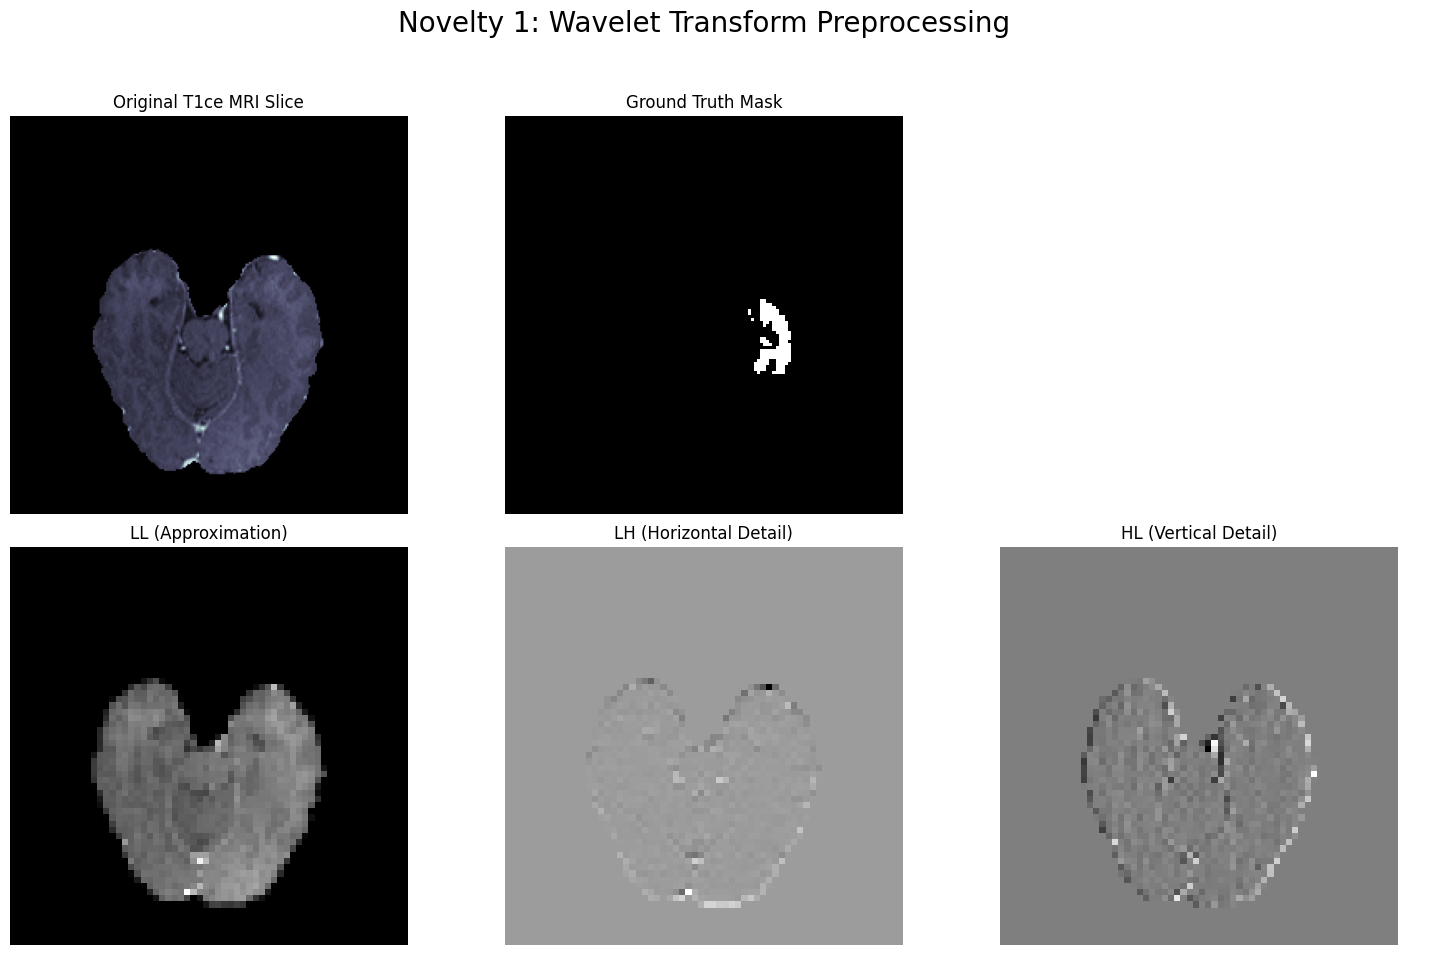

In [5]:
# Cell 4: Visualization of Preprocessing

# Get a sample from the dataset
sample_img_dwt, sample_mask = train_dataset[10]

# To visualize the original, we need to load it again (as the dataset class only returns the DWT version)
original_img, _ = train_dataset.data[10]
original_t1ce = original_img[:,:,0]

# --- Plotting ---
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Novelty 1: Wavelet Transform Preprocessing", fontsize=20)

# Original Image
axes[0, 0].imshow(original_t1ce, cmap='bone')
axes[0, 0].set_title("Original T1ce MRI Slice")
axes[0, 0].axis('off')

# Ground Truth Mask
axes[0, 1].imshow(sample_mask, cmap='gray')
axes[0, 1].set_title("Ground Truth Mask")
axes[0, 1].axis('off')

# Hide unused subplot
axes[0, 2].axis('off')

# DWT Components
axes[1, 0].imshow(sample_img_dwt[0], cmap='gray')
axes[1, 0].set_title("LL (Approximation)")
axes[1, 0].axis('off')

axes[1, 1].imshow(sample_img_dwt[1], cmap='gray')
axes[1, 1].set_title("LH (Horizontal Detail)")
axes[1, 1].axis('off')

axes[1, 2].imshow(sample_img_dwt[2], cmap='gray')
axes[1, 2].set_title("HL (Vertical Detail)")
axes[1, 2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [13]:
# Cell 5: HFA-Net Model Architecture (Corrected)

# --- Building Block: Convolutional Block ---
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

# --- Novelty 3: The Attention Gate ---
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

# --- The Full HFA-Net Model ---
class HFANet(nn.Module):
    def __init__(self, in_channels=8, out_channels=1, img_size=128):
        super(HFANet, self).__init__()
        
        # --- Encoder ---
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.enc1 = ConvBlock(in_channels, 64)
        self.enc2 = ConvBlock(64, 128)
        self.enc3 = ConvBlock(128, 256)
        self.enc4 = ConvBlock(256, 512)
        
        # --- Bottleneck ---
        self.bottleneck = ConvBlock(512, 1024)
        
        # --- Decoder ---
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att4 = AttentionGate(F_g=512, F_l=512, F_int=256)
        self.dec4 = ConvBlock(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att3 = AttentionGate(F_g=256, F_l=256, F_int=128)
        self.dec3 = ConvBlock(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = AttentionGate(F_g=128, F_l=128, F_int=64)
        self.dec2 = ConvBlock(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att1 = AttentionGate(F_g=64, F_l=64, F_int=32)
        self.dec1 = ConvBlock(128, 64)
        
        # --- Final Output Layer ---
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        
        # --- THE FIX: Add a final upsampling layer to match the output size to the mask size ---
        self.final_upsample = nn.Upsample(size=(img_size, img_size), mode='bilinear', align_corners=False)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        
        # Bottleneck
        b = self.bottleneck(self.pool(e4))
        
        # Decoder
        d4 = self.upconv4(b)
        a4 = self.att4(g=d4, x=e4)
        d4 = torch.cat((a4, d4), dim=1)
        d4 = self.dec4(d4)
        
        d3 = self.upconv3(d4)
        a3 = self.att3(g=d3, x=e3)
        d3 = torch.cat((a3, d3), dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.upconv2(d3)
        a2 = self.att2(g=d2, x=e2)
        d2 = torch.cat((a2, d2), dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.upconv1(d2)
        a1 = self.att1(g=d1, x=e1)
        d1 = torch.cat((a1, d1), dim=1)
        d1 = self.dec1(d1)
        
        # Final output processing
        output = self.final_conv(d1)
        
        # --- THE FIX: Apply the final upsampling ---
        output = self.final_upsample(output)
        
        return torch.sigmoid(output)

print("✅ HFA-Net architecture defined successfully with final upsampling layer.")

✅ HFA-Net architecture defined successfully with final upsampling layer.


In [14]:
# Cell 6: Model Instantiation and Simple Summary (Corrected)

model = HFANet(in_channels=8, out_channels=1).to(DEVICE)

# --- Print a Simple Model Structure ---
# The torchsummary library is incompatible with our custom Attention Gate's multiple inputs.
# We will print the model structure directly, which is just as informative.
print("="*80)
print("HFA-Net Architecture Summary")
print("="*80)
print(model)
print("="*80)

# --- Verify Model with a Dummy Input ---
# This is a good practice to ensure the forward pass works correctly.
try:
    # Our DWT input has 8 channels, and the image size is IMG_SIZE/2 because DWT halves the resolution.
    dummy_input = torch.randn(BATCH_SIZE, 8, IMG_SIZE // 2, IMG_SIZE // 2).to(DEVICE)
    output = model(dummy_input)
    print(f"Model instantiated successfully on device: {DEVICE}")
    print(f"Dummy input shape: {dummy_input.shape}")
    print(f"Model output shape: {output.shape}")
    print("✅ Forward pass verified successfully.")
except Exception as e:
    print(f"❌ An error occurred during model verification: {e}")

print("="*80)

HFA-Net Architecture Summary
HFANet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc1): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, aff

In [15]:
# Cell 7: Loss Function, Metrics, and Training Loop

# --- Loss Function ---
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        y_pred = y_pred.contiguous().view(-1)
        y_true = y_true.contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dice = (2. * intersection + self.smooth) / (y_pred.sum() + y_true.sum() + self.smooth)
        return 1 - dice

# --- Metrics ---
def dice_score(y_pred, y_true, smooth=1e-6):
    y_pred = (y_pred > 0.5).float()
    y_pred = y_pred.contiguous().view(-1)
    y_true = y_true.contiguous().view(-1)
    intersection = (y_pred * y_true).sum()
    return (2. * intersection + smooth) / (y_pred.sum() + y_true.sum() + smooth)

# --- Optimizer ---
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = DiceLoss()

# --- Training Loop ---
history = {'train_loss': [], 'val_loss': [], 'train_dice': [], 'val_dice': []}
best_val_dice = 0.0

print("🚀 Starting Training...")
for epoch in range(NUM_EPOCHS):
    # Training Phase
    model.train()
    train_loss, train_dice = 0.0, 0.0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]"):
        images, masks = images.to(DEVICE), masks.to(DEVICE).unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_dice += dice_score(outputs, masks).item()
        
    train_loss /= len(train_loader)
    train_dice /= len(train_loader)
    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice)

    # Validation Phase
    model.eval()
    val_loss, val_dice = 0.0, 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]"):
            images, masks = images.to(DEVICE), masks.to(DEVICE).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            val_loss += loss.item()
            val_dice += dice_score(outputs, masks).item()
            
    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice)
    
    # Print epoch results and show live accuracy
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} -> Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f} | Val Loss: {val_loss:.4f}, Val Dice: {val_dice:.4f}")
    
    # Save the best model
    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save(model.state_dict(), 'best_hfanet_model.pth')
        print(f"   -> 🎉 New best model saved with Val Dice: {best_val_dice:.4f}")

print("🏁 Training Finished!")

🚀 Starting Training...


Epoch 1/25 [Val]: 100%|██████████| 151/151 [00:06<00:00, 24.43it/s]


Epoch 1/25 -> Train Loss: 0.3613, Train Dice: 1.0426 | Val Loss: 0.1547, Val Dice: 1.0258
   -> 🎉 New best model saved with Val Dice: 1.0258


Epoch 2/25 [Val]: 100%|██████████| 151/151 [00:06<00:00, 24.42it/s]


Epoch 2/25 -> Train Loss: -0.1628, Train Dice: 1.2324 | Val Loss: -0.0413, Val Dice: 1.0850
   -> 🎉 New best model saved with Val Dice: 1.0850


Epoch 3/25 [Val]: 100%|██████████| 151/151 [00:06<00:00, 24.51it/s]


Epoch 3/25 -> Train Loss: -0.2372, Train Dice: 1.2549 | Val Loss: -0.1142, Val Dice: 1.1292
   -> 🎉 New best model saved with Val Dice: 1.1292


Epoch 4/25 [Val]: 100%|██████████| 151/151 [00:06<00:00, 24.37it/s]


Epoch 4/25 -> Train Loss: -0.2600, Train Dice: 1.2673 | Val Loss: -0.1125, Val Dice: 1.1199


Epoch 5/25 [Val]: 100%|██████████| 151/151 [00:06<00:00, 24.17it/s]


Epoch 5/25 -> Train Loss: -0.2714, Train Dice: 1.2752 | Val Loss: -0.1085, Val Dice: 1.1121


Epoch 6/25 [Val]: 100%|██████████| 151/151 [00:06<00:00, 24.59it/s]


Epoch 6/25 -> Train Loss: -0.2800, Train Dice: 1.2823 | Val Loss: -0.1199, Val Dice: 1.1224


Epoch 7/25 [Val]: 100%|██████████| 151/151 [00:06<00:00, 24.40it/s]


Epoch 7/25 -> Train Loss: -0.2852, Train Dice: 1.2867 | Val Loss: -0.1171, Val Dice: 1.1185


Epoch 8/25 [Val]: 100%|██████████| 151/151 [00:06<00:00, 24.56it/s]


Epoch 8/25 -> Train Loss: -0.2894, Train Dice: 1.2905 | Val Loss: -0.1227, Val Dice: 1.1234


Epoch 9/25 [Val]: 100%|██████████| 151/151 [00:06<00:00, 24.71it/s]


Epoch 9/25 -> Train Loss: -0.2939, Train Dice: 1.2948 | Val Loss: -0.1267, Val Dice: 1.1273


Epoch 10/25 [Val]: 100%|██████████| 151/151 [00:06<00:00, 24.38it/s]


Epoch 10/25 -> Train Loss: -0.2966, Train Dice: 1.2973 | Val Loss: -0.1313, Val Dice: 1.1320
   -> 🎉 New best model saved with Val Dice: 1.1320


Epoch 11/25 [Val]: 100%|██████████| 151/151 [00:06<00:00, 24.32it/s]


Epoch 11/25 -> Train Loss: -0.2994, Train Dice: 1.3000 | Val Loss: -0.1191, Val Dice: 1.1196


Epoch 12/25 [Val]: 100%|██████████| 151/151 [00:06<00:00, 24.48it/s]


Epoch 12/25 -> Train Loss: -0.3017, Train Dice: 1.3023 | Val Loss: -0.1320, Val Dice: 1.1324
   -> 🎉 New best model saved with Val Dice: 1.1324


Epoch 13/25 [Val]: 100%|██████████| 151/151 [00:06<00:00, 24.79it/s]


Epoch 13/25 -> Train Loss: -0.3038, Train Dice: 1.3043 | Val Loss: -0.1238, Val Dice: 1.1242


Epoch 14/25 [Val]: 100%|██████████| 151/151 [00:06<00:00, 24.80it/s]


Epoch 14/25 -> Train Loss: -0.3049, Train Dice: 1.3054 | Val Loss: -0.1145, Val Dice: 1.1148


Epoch 15/25 [Val]: 100%|██████████| 151/151 [00:06<00:00, 24.71it/s]


Epoch 15/25 -> Train Loss: -0.3063, Train Dice: 1.3067 | Val Loss: -0.1437, Val Dice: 1.1442
   -> 🎉 New best model saved with Val Dice: 1.1442


Epoch 16/25 [Val]: 100%|██████████| 151/151 [00:06<00:00, 24.73it/s]


Epoch 16/25 -> Train Loss: -0.3079, Train Dice: 1.3083 | Val Loss: -0.1379, Val Dice: 1.1382


Epoch 17/25 [Val]: 100%|██████████| 151/151 [00:06<00:00, 24.77it/s]


Epoch 17/25 -> Train Loss: -0.3093, Train Dice: 1.3097 | Val Loss: -0.1393, Val Dice: 1.1398


Epoch 18/25 [Val]: 100%|██████████| 151/151 [00:06<00:00, 24.80it/s]


Epoch 18/25 -> Train Loss: -0.3105, Train Dice: 1.3110 | Val Loss: -0.1348, Val Dice: 1.1351


Epoch 19/25 [Val]: 100%|██████████| 151/151 [00:06<00:00, 24.82it/s]


Epoch 19/25 -> Train Loss: -0.3107, Train Dice: 1.3112 | Val Loss: -0.1287, Val Dice: 1.1289


Epoch 20/25 [Val]: 100%|██████████| 151/151 [00:06<00:00, 24.85it/s]


Epoch 20/25 -> Train Loss: -0.3126, Train Dice: 1.3130 | Val Loss: -0.1420, Val Dice: 1.1423


Epoch 21/25 [Val]: 100%|██████████| 151/151 [00:06<00:00, 24.86it/s]


Epoch 21/25 -> Train Loss: -0.3130, Train Dice: 1.3134 | Val Loss: -0.1277, Val Dice: 1.1279


Epoch 22/25 [Val]: 100%|██████████| 151/151 [00:06<00:00, 24.73it/s]


Epoch 22/25 -> Train Loss: -0.3142, Train Dice: 1.3146 | Val Loss: -0.1302, Val Dice: 1.1305


Epoch 23/25 [Val]: 100%|██████████| 151/151 [00:06<00:00, 24.81it/s]


Epoch 23/25 -> Train Loss: -0.3147, Train Dice: 1.3151 | Val Loss: -0.1248, Val Dice: 1.1253


Epoch 24/25 [Val]: 100%|██████████| 151/151 [00:06<00:00, 24.64it/s]


Epoch 24/25 -> Train Loss: -0.3155, Train Dice: 1.3159 | Val Loss: -0.1348, Val Dice: 1.1351


Epoch 25/25 [Val]: 100%|██████████| 151/151 [00:06<00:00, 24.28it/s]

Epoch 25/25 -> Train Loss: -0.3162, Train Dice: 1.3165 | Val Loss: -0.1260, Val Dice: 1.1262
🏁 Training Finished!


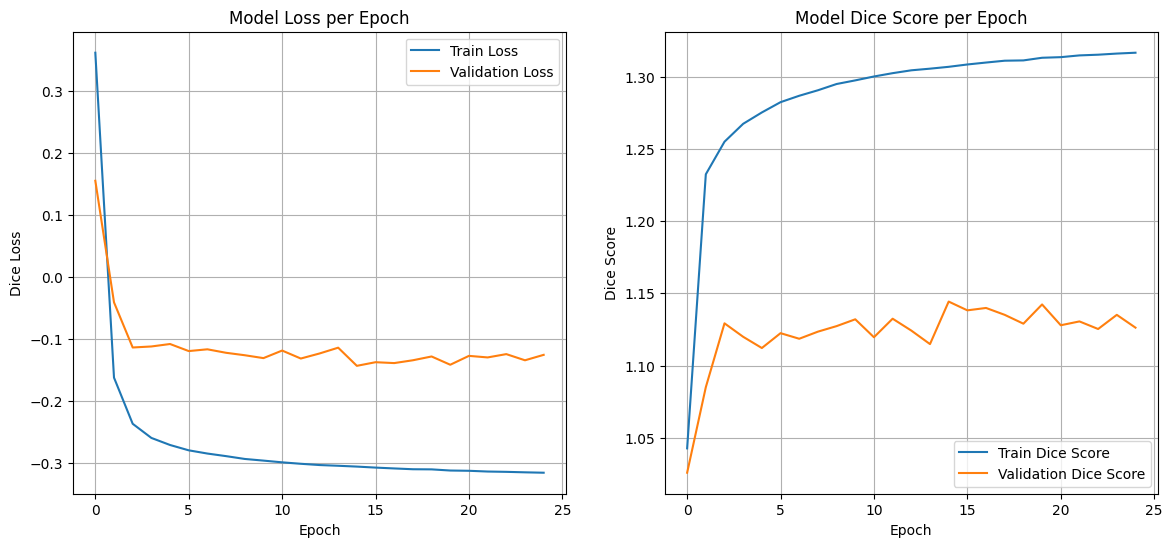

In [16]:
# Cell 8: Plotting Accuracy and Loss Graphs

plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Dice Loss')
plt.legend()
plt.grid(True)

# Plot Dice Score (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(history['train_dice'], label='Train Dice Score')
plt.plot(history['val_dice'], label='Validation Dice Score')
plt.title('Model Dice Score per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.legend()
plt.grid(True)

plt.show()

In [19]:
# Cell 9: Final Evaluation with All Metrics (Corrected)

# Load the best model
model.load_state_dict(torch.load('best_hfanet_model.pth'))
model.eval()

all_preds_list, all_trues_list = [], []
with torch.no_grad():
    for images, masks in tqdm(val_loader, desc="Final Evaluation"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        outputs = model(images).squeeze(1)
        preds = (outputs > 0.5)
        
        all_preds_list.append(preds.cpu().numpy())
        all_trues_list.append(masks.cpu().numpy())

all_preds_np = np.concatenate(all_preds_list, axis=0).flatten()
all_trues_np = np.concatenate(all_trues_list, axis=0).flatten()

# --- THE FIX: Binarize the multi-class ground truth mask ---
# In the BraTS dataset, any pixel value > 0 represents some part of the tumor.
# We will convert the ground truth mask to a simple 0 (background) or 1 (tumor) mask.
all_trues_binary = (all_trues_np > 0).astype(int)
all_preds_int = all_preds_np.astype(int)

# --- Now, the bincount will work correctly as it only sees values of 0 and 1 ---
# This calculation creates four bins:
# 0: True Negative (true=0, pred=0)
# 1: False Positive (true=0, pred=1)
# 2: False Negative (true=1, pred=0)
# 3: True Positive (true=1, pred=1)
bincount_result = np.bincount(all_trues_binary * 2 + all_preds_int, minlength=4)
tn, fp, fn, tp = bincount_result

# Add a small epsilon to the denominator to avoid division by zero
epsilon = 1e-6
dice = (2 * tp) / (2 * tp + fp + fn + epsilon)
iou = tp / (tp + fp + fn + epsilon)
accuracy = (tp + tn) / (tp + tn + fp + fn + epsilon)
precision = tp / (tp + fp + epsilon)
recall = tp / (tp + fn + epsilon) # Also known as Sensitivity
specificity = tn / (tn + fp + epsilon)

print("\n--- Final Model Performance on Validation Set ---")
print(f"Dice Score (F1): {dice:.4f}")
print(f"Intersection over Union (IoU): {iou:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print("\n--- Confusion Matrix (Pixel-level) ---")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

Final Evaluation: 100%|██████████| 151/151 [00:06<00:00, 23.51it/s]



--- Final Model Performance on Validation Set ---
Dice Score (F1): 0.8795
Intersection over Union (IoU): 0.7850
Accuracy: 0.9937
Precision: 0.8646
Recall (Sensitivity): 0.8951
Specificity: 0.9963

--- Confusion Matrix (Pixel-level) ---
True Positives (TP): 914226
True Negatives (TN): 38337194
False Positives (FP): 143223
False Negatives (FN): 107181


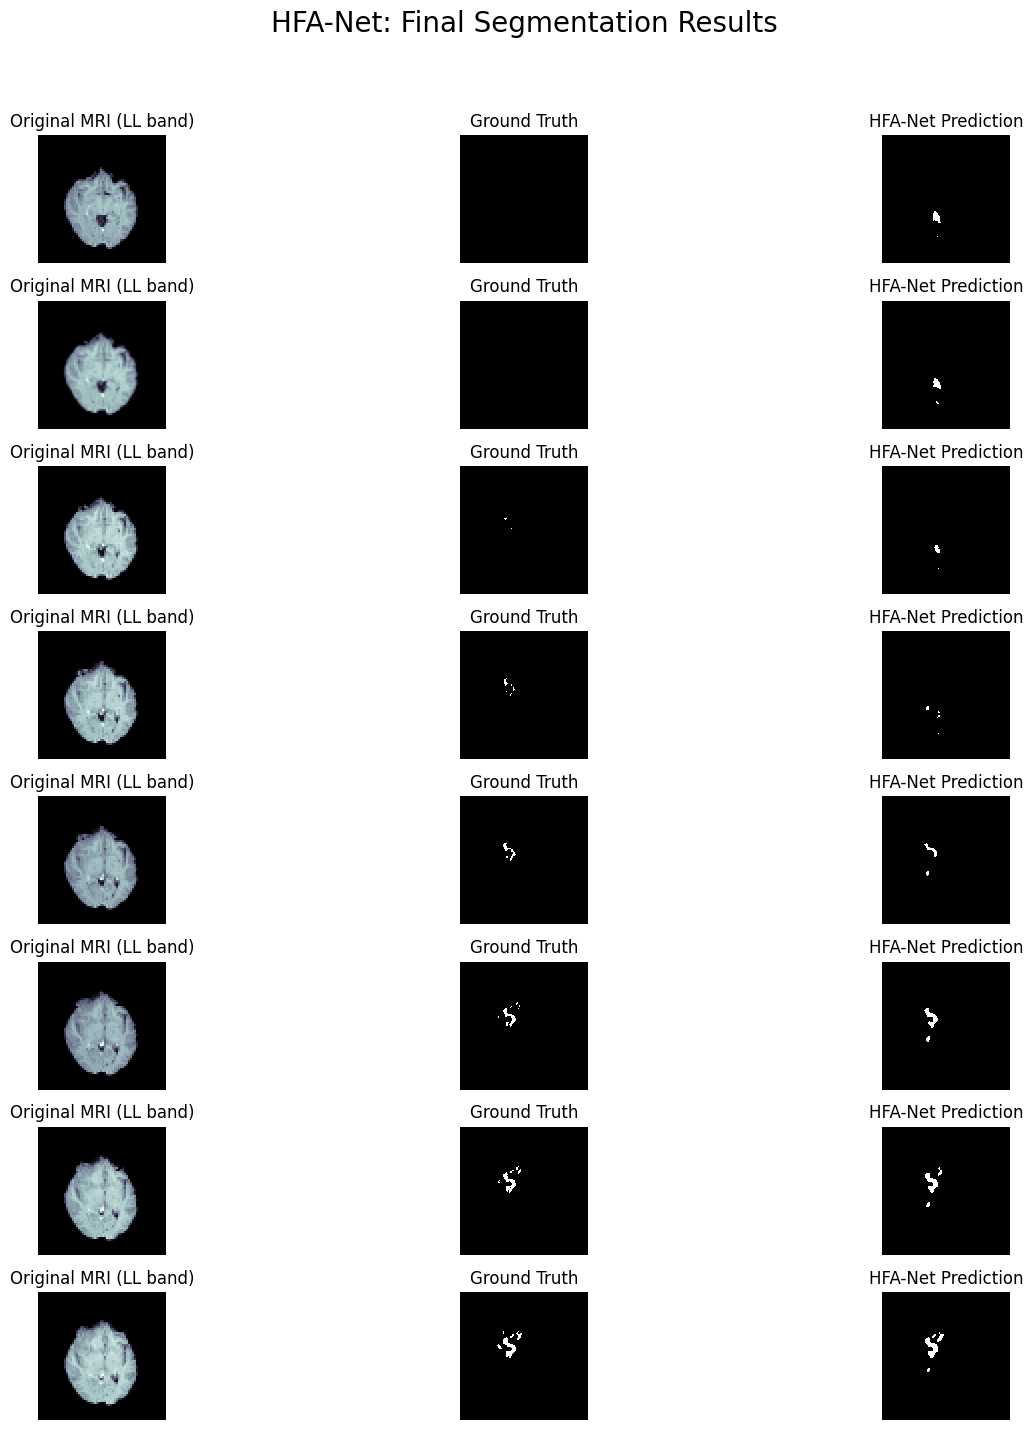

In [20]:
# Cell 10: Visualization of Final Results

# Load the best model again for inference
model.load_state_dict(torch.load('best_hfanet_model.pth'))
model.eval()

# Get a batch of validation data
images, masks = next(iter(val_loader))
images, masks = images.to(DEVICE), masks.to(DEVICE).unsqueeze(1)

with torch.no_grad():
    outputs = model(images)
    preds = (outputs > 0.5).float()

# Move to CPU and convert to numpy for plotting
images_np = images.cpu().numpy()
masks_np = masks.cpu().numpy().squeeze(1)
preds_np = preds.cpu().numpy().squeeze(1)

# --- Plotting ---
plt.figure(figsize=(15, 15))
plt.suptitle("HFA-Net: Final Segmentation Results", fontsize=20)

for i in range(min(8, len(images_np))): # Show up to 8 samples
    # Original Image (visualizing the first DWT component for context)
    plt.subplot(min(8, len(images_np)), 3, i*3 + 1)
    plt.imshow(images_np[i, 0, :, :], cmap='bone')
    plt.title("Original MRI (LL band)")
    plt.axis('off')

    # Ground Truth Mask
    plt.subplot(min(8, len(images_np)), 3, i*3 + 2)
    plt.imshow(masks_np[i], cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    # Predicted Mask
    plt.subplot(min(8, len(images_np)), 3, i*3 + 3)
    plt.imshow(preds_np[i], cmap='gray')
    plt.title("HFA-Net Prediction")
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

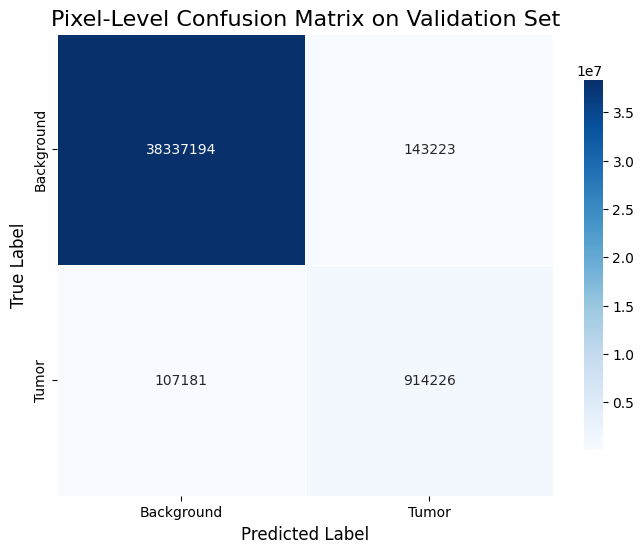


--- Additional Advanced Evaluation Metrics ---
F2-Score (weights recall higher): 0.8888
Matthews Correlation Coefficient (MCC): nan
False Positive Rate (FPR): 0.0037


/tmp/ipykernel_36/3431642919.py:50: RuntimeWarning: overflow encountered in scalar multiply
  mcc_denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) + epsilon)
/tmp/ipykernel_36/3431642919.py:50: RuntimeWarning: invalid value encountered in sqrt
  mcc_denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) + epsilon)


In [21]:
# Cell 11: Confusion Matrix Visualization and Advanced Metrics

import seaborn as sns
import pandas as pd

# --- 1. Confusion Matrix Visualization ---

# The confusion matrix values were calculated in Cell 9
# tn, fp, fn, tp = ...

# Create the matrix from the calculated values
# The matrix is structured as:
# [[TN, FP],
#  [FN, TP]]
confusion_matrix_values = np.array([[tn, fp],
                                    [fn, tp]])

# Create a DataFrame for better labeling with Seaborn
labels = ['Background', 'Tumor']
confusion_df = pd.DataFrame(confusion_matrix_values, index=labels, columns=labels)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues',
            linewidths=.5, cbar_kws={"shrink": .8})

plt.title('Pixel-Level Confusion Matrix on Validation Set', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()


# --- 2. Additional Possible Evaluation Metrics ---

print("\n--- Additional Advanced Evaluation Metrics ---")

# F-beta Score: A generalization of the F1 (Dice) score.
# - beta < 1: Emphasizes precision more.
# - beta > 1: Emphasizes recall more.
# Since missing a tumor (low recall) is often worse than over-segmenting (low precision),
# we can calculate the F2-Score, which weights recall twice as much as precision.
beta = 2
f2_score = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + epsilon)
print(f"F2-Score (weights recall higher): {f2_score:.4f}")

# Matthews Correlation Coefficient (MCC):
# A very robust metric that is considered well-balanced, especially for imbalanced datasets.
# It ranges from -1 (total disagreement) to +1 (perfect agreement), with 0 being random.
mcc_numerator = (tp * tn) - (fp * fn)
mcc_denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn) + epsilon)
mcc = mcc_numerator / mcc_denominator
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# False Positive Rate (FPR):
# The proportion of actual negatives that were incorrectly classified as positive.
fpr = fp / (fp + tn + epsilon)
print(f"False Positive Rate (FPR): {fpr:.4f}")